In [35]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
import copy
sns.set() 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

## Prepping data for model construction

In [53]:
data = pd.read_csv("vecs_with_feature.csv")
data.head(2)

,Bill Name,Vec1,Vec2,Vec3,Vec4,Vec5,Vec6,Vec7,Vec8,Vec9,...,VersionDate,Pages,BillText,VersionType,VersionURL,BillIterations,Category_clean,year,Author,PoliticalAffiliation
0,A 10015,0.013685,0.015255,0.001146,-0.003181,-0.045341,0.045083,0.029060,0.036673,0.026858,...,5/1/2024,2.0,the following has special meaning:green underl...,Introduced,https://custom.statenet.com/public/resources.c...,1,Private Sector Use,2024,Lavine,D
1,A 10020,0.032183,0.020277,-0.032746,0.007811,-0.010392,0.056031,-0.000438,0.033367,0.034230,...,5/1/2024,2.0,the following has special meaning:green underl...,Introduced,https://custom.statenet.com/public/resources.c...,1,Housing,2024,Rosenthal,D


In [54]:
print(list(data.columns))

['Bill Name', 'Vec1', 'Vec2', 'Vec3', 'Vec4', 'Vec5', 'Vec6', 'Vec7', 'Vec8', 'Vec9', 'Vec10', 'Vec11', 'Vec12', 'Vec13', 'Vec14', 'Vec15', 'Vec16', 'Vec17', 'Vec18', 'Vec19', 'Vec20', 'Vec21', 'Vec22', 'Vec23', 'Vec24', 'Vec25', 'Vec26', 'Vec27', 'Vec28', 'Vec29', 'Vec30', 'Vec31', 'Vec32', 'Vec33', 'Vec34', 'Vec35', 'Vec36', 'Vec37', 'Vec38', 'Vec39', 'Vec40', 'Vec41', 'Vec42', 'Vec43', 'Vec44', 'Vec45', 'Vec46', 'Vec47', 'Vec48', 'Vec49', 'Vec50', 'Vec51', 'Vec52', 'Vec53', 'Vec54', 'Vec55', 'Vec56', 'Vec57', 'Vec58', 'Vec59', 'Vec60', 'Vec61', 'Vec62', 'Vec63', 'Vec64', 'Vec65', 'Vec66', 'Vec67', 'Vec68', 'Vec69', 'Vec70', 'Vec71', 'Vec72', 'Vec73', 'Vec74', 'Vec75', 'Vec76', 'Vec77', 'Vec78', 'Vec79', 'Vec80', 'Vec81', 'Vec82', 'Vec83', 'Vec84', 'Vec85', 'Vec86', 'Vec87', 'Vec88', 'Vec89', 'Vec90', 'Vec91', 'Vec92', 'Vec93', 'Vec94', 'Vec95', 'Vec96', 'Vec97', 'Vec98', 'Vec99', 'Vec100', 'Vec101', 'Vec102', 'Vec103', 'Vec104', 'Vec105', 'Vec106', 'Vec107', 'Vec108', 'Vec109', 'Vec

In [55]:
passfail = data[data['BillStatus'] != 'Pending']

In [56]:
passfail.head(2)

,Bill Name,Vec1,Vec2,Vec3,Vec4,Vec5,Vec6,Vec7,Vec8,Vec9,...,VersionDate,Pages,BillText,VersionType,VersionURL,BillIterations,Category_clean,year,Author,PoliticalAffiliation
5,A 10556,-0.018296,0.017080,-0.013930,0.012935,-0.013782,0.054763,0.011631,0.006744,0.057870,...,6/3/2024,4.0,the following has special meaning:green underl...,Introduced,https://custom.statenet.com/public/resources.c...,1,Appropriations,2024,Rules,NaN
9,A 1158,-0.017504,0.067952,-0.037426,-0.031573,-0.009825,0.036916,0.010284,0.012268,0.013477,...,3/22/2024,1.0,the following has special meaning:green underl...,Introduced,https://custom.statenet.com/public/resources.c...,1,Notification,2024,Palmeri,D


In [57]:
columns_to_keep = ['Bill Name', 'Jurisdiction', 'BillIterations', 'year', 'Category_clean', 'Author', 'PoliticalAffiliation', 'BillStatus'] + [col for col in data.columns if col.startswith('Vec')]

passfail = passfail[columns_to_keep]

print(passfail.head())

   Bill Name Jurisdiction  BillIterations  year  Category_clean   Author  \
5    A 10556     New York               1  2024  Appropriations    Rules   
9     A 1158    Wisconsin               1  2024    Notification  Palmeri   
11    A 1502   California               1  2024      Health Use  Schiavo   
21     A 302   California               2  2023  Government Use     Ward   
54    A 8328     New York               1  2024           Audit   Joyner   

   PoliticalAffiliation BillStatus      Vec1      Vec2  ...    Vec759  \
5                   NaN     Failed -0.018296  0.017080  ... -0.021043   
9                     D     Failed -0.017504  0.067952  ...  0.002351   
11                    D     Failed  0.055256  0.060898  ... -0.004150   
21                    D    Enacted  0.020211  0.054371  ... -0.019527   
54                    D     Failed  0.008555 -0.007567  ... -0.011284   

      Vec760    Vec761    Vec762    Vec763    Vec764    Vec765    Vec766  \
5  -0.000234 -0.009391  0.01

In [58]:
categorical_cols = passfail.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols.tolist())

Categorical columns: ['Bill Name', 'Jurisdiction', 'Category_clean', 'Author', 'PoliticalAffiliation', 'BillStatus']


## Ready to start building some models

### 1) Random Forest

#### Initial effort

In [59]:
le = LabelEncoder()
passfail['BillStatus'] = le.fit_transform(passfail['BillStatus'])
for col in categorical_cols:
    passfail[col] = le.fit_transform(passfail[col])

# Define features (X) and target (y)
X = passfail.drop(columns=['BillStatus', 'Bill Name']) 
y = passfail['BillStatus']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7407


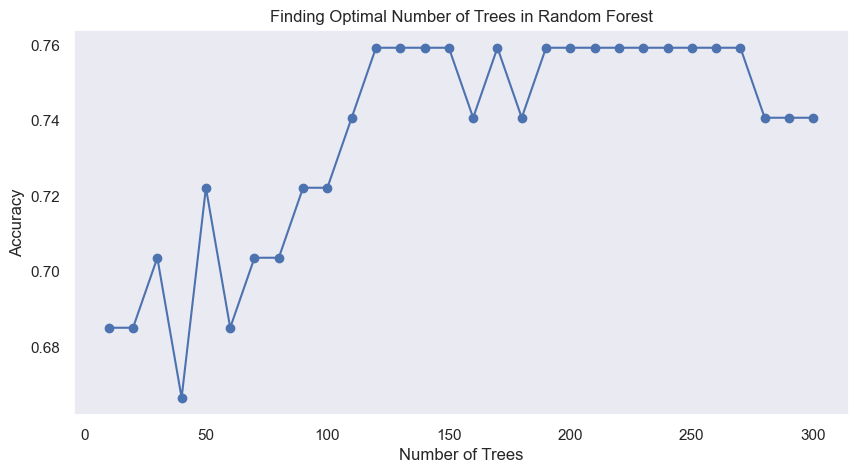

Optimal number of trees: 120 with accuracy: 0.7593


In [60]:
# Testing from 10 to 300 trees, in steps of 10

n_trees = range(10, 310, 10) 
accuracies = []

# Train and evaluate models with different numbers of trees
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot accuracy vs. number of trees
plt.figure(figsize=(10, 5))
plt.plot(n_trees, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Finding Optimal Number of Trees in Random Forest')
plt.grid()
plt.show()

# Print the best number of trees
best_n = n_trees[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"Optimal number of trees: {best_n} with accuracy: {best_acc:.4f}")

#### Using optimal number of trees

In [61]:
le = LabelEncoder()
passfail['BillStatus'] = le.fit_transform(passfail['BillStatus'])
for col in categorical_cols:
    passfail[col] = le.fit_transform(passfail[col])

# Define features (X) and target (y)
X = passfail.drop(columns=['BillStatus', 'Bill Name']) 
y = passfail['BillStatus']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=120, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7593


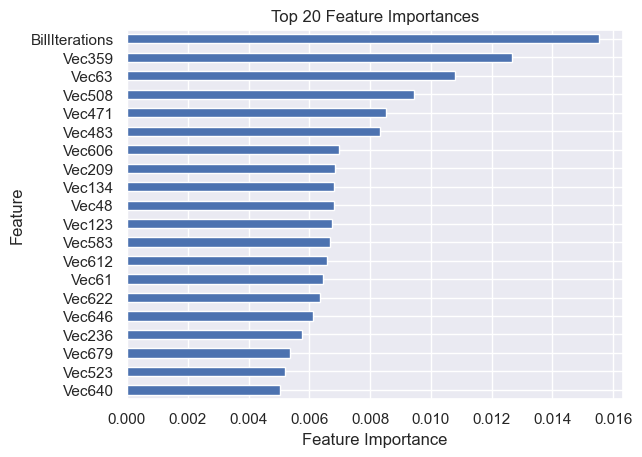

In [62]:
# Retrieve feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# Sort and plot the top 20 features
top_features = feature_importances.sort_values(ascending=False).head(20)
top_features.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### So, my document vectors dominate by virtue of their quantity. I want all the vectors collectively to be considered in equal weight with the other variables

In [63]:
# Identify document vector columns
doc_vec_cols = [col for col in passfail.columns if col.startswith('Vec')]

# Scale document vector features
scaling_factor = 6 / 768  # Adjust this factor as needed
passfail[doc_vec_cols] = passfail[doc_vec_cols] * scaling_factor

In [64]:
le = LabelEncoder()
passfail['BillStatus'] = le.fit_transform(passfail['BillStatus'])
for col in categorical_cols:
    passfail[col] = le.fit_transform(passfail[col])

# Define features (X) and target (y)
X = passfail.drop(columns=['BillStatus', 'Bill Name']) 
y = passfail['BillStatus']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=120, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7593


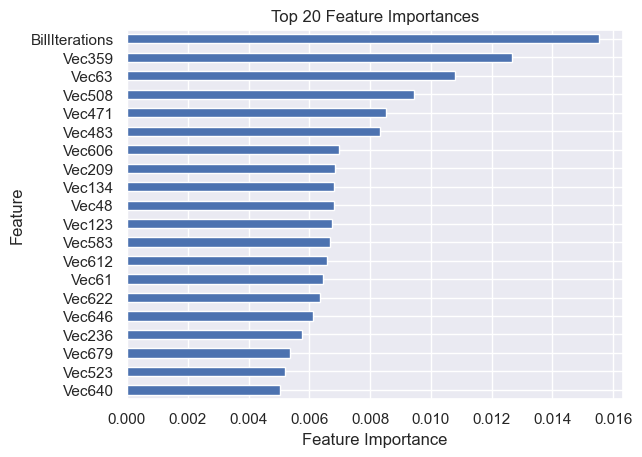

In [65]:
# Retrieve feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# Sort and plot the top 20 features
top_features = feature_importances.sort_values(ascending=False).head(20)
top_features.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Hmm. Vector scaling doesn't seem to be changing much, but this may have something to do with the type of model (rf) rather than the scaling work itself. Let's try something else

In [66]:
from sklearn.decomposition import PCA

# This reduces the number of vector dimensions under consideration, while also doing little to dilute their overall value
pca = PCA(n_components=10)
vec_data = passfail[doc_vec_cols]
vec_pca = pca.fit_transform(vec_data)

# Adding back to passfail df
for i in range(vec_pca.shape[1]):
    passfail[f'vec_pca_{i}'] = vec_pca[:, i]

# Dropping the original vector dimensions
passfail = passfail.drop(columns=doc_vec_cols)

In [67]:
passfail.head(2)

,Bill Name,Jurisdiction,BillIterations,year,Category_clean,Author,PoliticalAffiliation,BillStatus,vec_pca_0,vec_pca_1,vec_pca_2,vec_pca_3,vec_pca_4,vec_pca_5,vec_pca_6,vec_pca_7,vec_pca_8,vec_pca_9
5,0,30,1,2024,0,130,2,1,-0.060191,-0.179042,-0.008030,-0.068632,-0.134557,0.080065,-0.123450,0.049655,-0.174621,0.013766
9,1,44,1,2024,14,109,0,1,0.295257,-0.029629,-0.116365,0.028050,0.092833,0.004784,-0.109831,0.014825,-0.036723,0.004648


In [68]:
le = LabelEncoder()
passfail['BillStatus'] = le.fit_transform(passfail['BillStatus'])
for col in categorical_cols:
    passfail[col] = le.fit_transform(passfail[col])

# Define features (X) and target (y)
X = passfail.drop(columns=['BillStatus', 'Bill Name']) 
y = passfail['BillStatus']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=120, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8333


### Way higher accuracy!

### Now I'll optimize the trees again

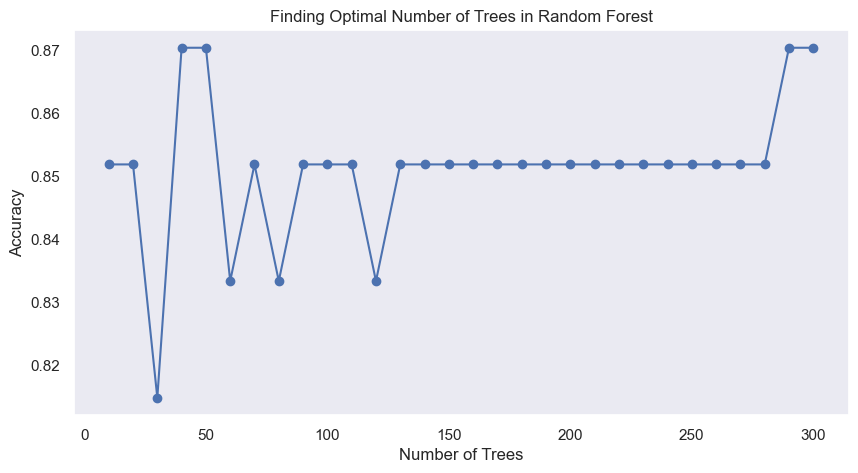

Optimal number of trees: 40 with accuracy: 0.8704


In [69]:
# Testing from 10 to 300 trees, in steps of 10

n_trees = range(10, 310, 10) 
accuracies = []

# Train and evaluate models with different numbers of trees
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot accuracy vs. number of trees
plt.figure(figsize=(10, 5))
plt.plot(n_trees, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Finding Optimal Number of Trees in Random Forest')
plt.grid()
plt.show()

# Print the best number of trees
best_n = n_trees[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"Optimal number of trees: {best_n} with accuracy: {best_acc:.4f}")

In [70]:
le = LabelEncoder()
passfail['BillStatus'] = le.fit_transform(passfail['BillStatus'])
for col in categorical_cols:
    passfail[col] = le.fit_transform(passfail[col])

# Define features (X) and target (y)
X = passfail.drop(columns=['BillStatus', 'Bill Name']) 
y = passfail['BillStatus']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=40, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8704


In [72]:
# Looking for average precision and recall too. Interested in the average because I am looking to predict both enactment and failure. Will look into 
# each explicitly once I identify the optimal model for prediction

precision = precision_score(y_test, y_pred, average='macro')  
recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8704
Precision: 0.8692
Recall: 0.8333


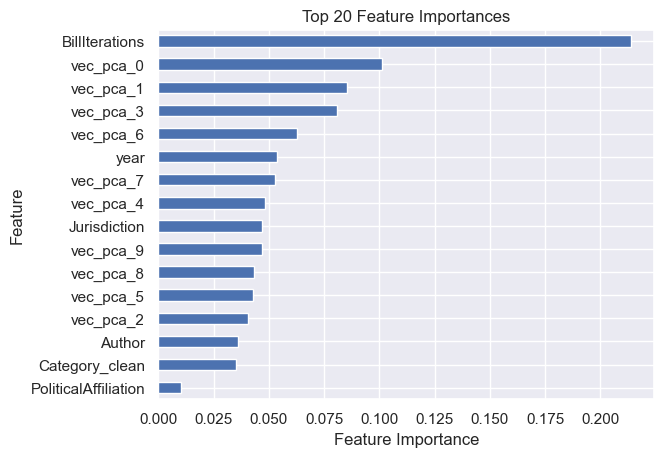

In [75]:
# Retrieve feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# Sort and plot the top 20 features
top_features = feature_importances.sort_values(ascending=False).head(20)
top_features.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## 2) Naive Bayes

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the Naive Bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict on the test set
y_pred = nb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7778


In [74]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7778
Precision: 0.7516
Recall: 0.7361


## 3) SVM

In [76]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the SVM classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6667


In [78]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6667
Precision: 0.3333
Recall: 0.5000


C:\Users\13037\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4) kNN

Best k: 5
Best accuracy: 0.6852


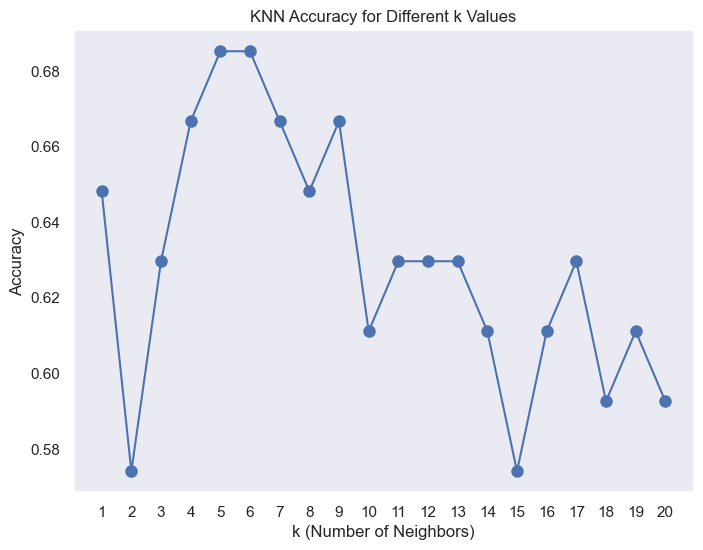

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initializing variables to track the best k and its accuracy
best_k = 1
best_accuracy = 0
k_values = range(1, 21)  # Trying k values from 1 to 20
accuracies = []

# Looping over possible k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

# Printing the best k and its accuracy
print(f"Best k: {best_k}")
print(f"Best accuracy: {best_accuracy:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies, marker='o', color='b', linestyle='-', markersize=8)
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different k Values')
plt.xticks(k_values)
plt.grid(False)
plt.show()

In [82]:
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

# Computing performance metrics based on best k
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='macro')  # or 'weighted'
recall = recall_score(y_test, y_pred_best, average='macro')  # or 'weighted'

print(f"Best k: {best_k}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best k: 5
Accuracy: 0.6852
Precision: 0.6332
Recall: 0.5972


## So, the rf model seems to perform much better than other ML models after an initial pass through (especially after dimensionality reduction completed on the document vectors). As such, I want to look at that model in more detail.

In [84]:
le = LabelEncoder()
passfail['BillStatus'] = le.fit_transform(passfail['BillStatus'])
for col in categorical_cols:
    passfail[col] = le.fit_transform(passfail[col])

# Define features (X) and target (y)
X = passfail.drop(columns=['BillStatus', 'Bill Name']) 
y = passfail['BillStatus']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=40, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8704


Text(0.5, 1.0, 'RF Bill Status Prediction Confusion Matrix\n(1 = Enacted, 0 = Failed)')

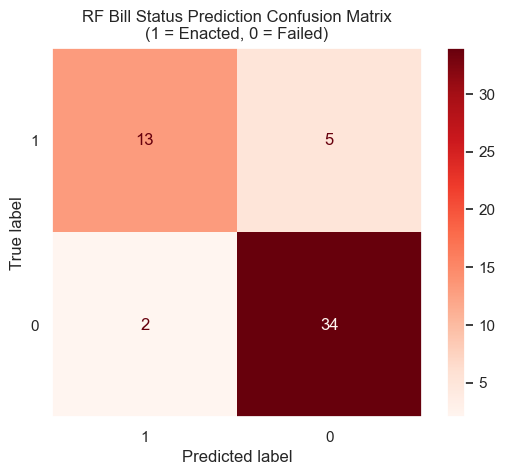

In [85]:
cm = confusion_matrix(y_test, y_pred)

# Step 3: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap='Reds')

plt.grid(False)
plt.title("RF Bill Status Prediction Confusion Matrix\n(1 = Enacted, 0 = Failed)")

## Now, can I predict the status of undetermined bills at the time of data collection to explore the possibility of practical application of this tool?

## Ten American states have a full-time state legislature, or one that runs after the date of last NCSl data update in September 2024. A full-time state legislature is defined as a legislature that meets throughout the year. All other legislatures are considered part-time because they only meet for a portion of the year.

The full-time state legislatures are:

Alaska State Legislature,
California State Legislature,
Hawaii State Legislature,
Illinois State Legislature,
Massachusetts State Legislature,
Michigan State Legislature,
New York State Legislature,
Ohio State Legislature,
Pennsylvania General Assembly,
Wisconsin State Legislature

https://ballotpedia.org/States_with_a_full-time_legislature#:~:text=Ten%20American%20states%20have%20a,Wisconsin%20State%20Legislature

## Can I predict the status of bills whose outcomes have been determined since data collection/updates took place?

In [87]:
pending = data[data['BillStatus'] == 'Pending']

In [90]:
pending = pending[columns_to_keep]

In [91]:
print(pending.head())

  Bill Name Jurisdiction  BillIterations  year      Category_clean     Author  \
0   A 10015     New York               1  2024  Private Sector Use     Lavine   
1   A 10020     New York               1  2024             Housing  Rosenthal   
2   A 10103     New York               3  2024        Notification      Vanel   
3   A 10374     New York               1  2024                 NaN      Rules   
4   A 10494     New York               1  2024      Government Use      Rules   

  PoliticalAffiliation BillStatus      Vec1      Vec2  ...    Vec759  \
0                    D    Pending  0.013685  0.015255  ...  0.010394   
1                    D    Pending  0.032183  0.020277  ... -0.013266   
2                    D    Pending -0.024261  0.056789  ...  0.024061   
3                  NaN    Pending -0.034454  0.025600  ... -0.007945   
4                  NaN    Pending -0.000095  0.046310  ...  0.012495   

     Vec760    Vec761    Vec762    Vec763    Vec764    Vec765    Vec766  \
0  0.

In [92]:
categorical_cols = pending.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols.tolist())

Categorical columns: ['Bill Name', 'Jurisdiction', 'Category_clean', 'Author', 'PoliticalAffiliation', 'BillStatus']


In [93]:
pca = PCA(n_components=10)
vec_data = pending[doc_vec_cols]
vec_pca = pca.fit_transform(vec_data)

# Adding back to passfail df
for i in range(vec_pca.shape[1]):
    pending[f'vec_pca_{i}'] = vec_pca[:, i]

# Dropping the original vector dimensions
pending = pending.drop(columns=doc_vec_cols)

In [94]:
pending.head(2)

,Bill Name,Jurisdiction,BillIterations,year,Category_clean,Author,PoliticalAffiliation,BillStatus,vec_pca_0,vec_pca_1,vec_pca_2,vec_pca_3,vec_pca_4,vec_pca_5,vec_pca_6,vec_pca_7,vec_pca_8,vec_pca_9
0,A 10015,New York,1,2024,Private Sector Use,Lavine,D,Pending,-0.030083,0.094984,-0.093061,0.142236,0.138733,-0.100095,-0.064611,0.000259,0.159971,0.006946
1,A 10020,New York,1,2024,Housing,Rosenthal,D,Pending,0.015539,0.142383,-0.187030,0.211304,0.053764,-0.167426,-0.030046,0.062893,0.016879,0.073440


## Ok, let's predict the outcome of these bills using the random forest model

In [109]:
# Step 1: Refitting label encoders on training data
encoders = {}
for col in categorical_cols:
    le_col = LabelEncoder()
    le_col.fit(passfail[col])
    encoders[col] = le_col

# Step 2: Preparing the pending data for prediction
pending_for_pred = pending.drop(columns=['Bill Name', 'BillStatus'], errors='ignore').copy()

# Step 3: Applying encoders to pending data
for col in categorical_cols:
    if col in pending_for_pred.columns:
        encoder = encoders[col]
        # Handle unseen categories (not present in training data)
        pending_for_pred[col] = pending_for_pred[col].apply(
            lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1
        )

# Step 4: Predicting using already created random forest model
pending_predictions = rf.predict(pending_for_pred)

# Step 5: Decoding numeric predictions back into original labels
predicted_labels = le.inverse_transform(pending_predictions)

# Step 6: Adding predictions to original df
pending['PredictedStatus'] = predicted_labels

In [110]:
pending.head(2)

,Bill Name,Jurisdiction,BillIterations,year,Category_clean,Author,PoliticalAffiliation,BillStatus,vec_pca_0,vec_pca_1,vec_pca_2,vec_pca_3,vec_pca_4,vec_pca_5,vec_pca_6,vec_pca_7,vec_pca_8,vec_pca_9,PredictedStatus
0,A 10015,New York,1,2024,Private Sector Use,Lavine,D,Pending,-0.030083,0.094984,-0.093061,0.142236,0.138733,-0.100095,-0.064611,0.000259,0.159971,0.006946,1
1,A 10020,New York,1,2024,Housing,Rosenthal,D,Pending,0.015539,0.142383,-0.187030,0.211304,0.053764,-0.167426,-0.030046,0.062893,0.016879,0.073440,1


In [111]:
print(le.classes_)

[0 1]


In [112]:
le.fit(passfail['BillStatus'])

print(le.classes_)

[0 1]


In [113]:
pending['PredictedStatus'] = pending['PredictedStatus'].replace({1: 'Failed', 0: 'Enacted'})
pending

,Bill Name,Jurisdiction,BillIterations,year,Category_clean,Author,PoliticalAffiliation,BillStatus,vec_pca_0,vec_pca_1,vec_pca_2,vec_pca_3,vec_pca_4,vec_pca_5,vec_pca_6,vec_pca_7,vec_pca_8,vec_pca_9,PredictedStatus
0,A 10015,New York,1,2024,Private Sector Use,Lavine,D,Pending,-0.030083,0.094984,-0.093061,0.142236,0.138733,-0.100095,-0.064611,0.000259,0.159971,0.006946,Failed
1,A 10020,New York,1,2024,Housing,Rosenthal,D,Pending,0.015539,0.142383,-0.187030,0.211304,0.053764,-0.167426,-0.030046,0.062893,0.016879,0.073440,Failed
2,A 10103,New York,3,2024,Notification,Vanel,D,Pending,0.274736,0.101493,0.069976,0.091364,0.088959,-0.089153,0.022586,-0.079912,-0.036467,-0.096184,Failed
3,A 10374,New York,1,2024,NaN,Rules,NaN,Pending,0.102989,-0.029667,-0.032216,0.079177,-0.071645,-0.187623,-0.053561,-0.144147,-0.142239,-0.118766,Failed
4,A 10494,New York,1,2024,Government Use,Rules,NaN,Pending,0.243177,0.046600,-0.020225,0.120299,0.096620,-0.048523,0.120146,-0.001069,-0.117732,0.037336,Failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,S 9640,New York,1,2024,Judicial Use,Hoylman,D,Pending,0.213344,0.111416,0.090277,0.042684,0.078680,0.014943,0.054982,0.019981,0.000918,-0.097393,Failed
410,S 970,California,2,2024,Judicial Use,Ashby,D,Pending,0.219468,-0.087214,-0.124685,-0.127586,-0.087003,-0.042867,0.150268,0.113057,-0.062013,0.012466,Failed
413,S 9832,New York,1,2024,Judicial Use,Hoylman,D,Pending,-0.006691,-0.105605,-0.186401,0.146458,0.005855,-0.096329,0.228501,-0.113321,0.039902,0.034651,Failed
415,SJR 114,New Jersey,2,2024,Criminal Use,Gopal,D,Pending,-0.014067,-0.095760,-0.041326,0.045779,-0.079924,0.028834,-0.062977,0.083897,-0.156167,0.188556,Failed


In [114]:
target_jurisdictions = ["Alaska", "California", "Hawaii", "Illionois", "Massachusetts", "Michigan", "New York", "Ohio", "Pennsylvania", "Wisconsin"]  # Replace with your desired values

# Filter the merged DataFrame
pending_full_time = pending[pending["Jurisdiction"].isin(target_jurisdictions)]
pending_full_time

,Bill Name,Jurisdiction,BillIterations,year,Category_clean,Author,PoliticalAffiliation,BillStatus,vec_pca_0,vec_pca_1,vec_pca_2,vec_pca_3,vec_pca_4,vec_pca_5,vec_pca_6,vec_pca_7,vec_pca_8,vec_pca_9,PredictedStatus
0,A 10015,New York,1,2024,Private Sector Use,Lavine,D,Pending,-0.030083,0.094984,-0.093061,0.142236,0.138733,-0.100095,-0.064611,0.000259,0.159971,0.006946,Failed
1,A 10020,New York,1,2024,Housing,Rosenthal,D,Pending,0.015539,0.142383,-0.187030,0.211304,0.053764,-0.167426,-0.030046,0.062893,0.016879,0.073440,Failed
2,A 10103,New York,3,2024,Notification,Vanel,D,Pending,0.274736,0.101493,0.069976,0.091364,0.088959,-0.089153,0.022586,-0.079912,-0.036467,-0.096184,Failed
3,A 10374,New York,1,2024,NaN,Rules,NaN,Pending,0.102989,-0.029667,-0.032216,0.079177,-0.071645,-0.187623,-0.053561,-0.144147,-0.142239,-0.118766,Failed
4,A 10494,New York,1,2024,Government Use,Rules,NaN,Pending,0.243177,0.046600,-0.020225,0.120299,0.096620,-0.048523,0.120146,-0.001069,-0.117732,0.037336,Failed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,S 9609,New York,1,2024,Housing,Krueger,D,Pending,-0.019226,0.036007,-0.110378,0.202277,0.040744,-0.151772,-0.046085,0.022300,-0.071189,-0.023033,Failed
409,S 9640,New York,1,2024,Judicial Use,Hoylman,D,Pending,0.213344,0.111416,0.090277,0.042684,0.078680,0.014943,0.054982,0.019981,0.000918,-0.097393,Failed
410,S 970,California,2,2024,Judicial Use,Ashby,D,Pending,0.219468,-0.087214,-0.124685,-0.127586,-0.087003,-0.042867,0.150268,0.113057,-0.062013,0.012466,Failed
413,S 9832,New York,1,2024,Judicial Use,Hoylman,D,Pending,-0.006691,-0.105605,-0.186401,0.146458,0.005855,-0.096329,0.228501,-0.113321,0.039902,0.034651,Failed


In [115]:
pending_full_time['Jurisdiction'].value_counts()

Jurisdiction
New York         67
California       31
Pennsylvania     17
Massachusetts    14
Wisconsin         2
Michigan          1
Ohio              1
Name: count, dtype: int64

In [116]:
pending_full_time.head(3)

,Bill Name,Jurisdiction,BillIterations,year,Category_clean,Author,PoliticalAffiliation,BillStatus,vec_pca_0,vec_pca_1,vec_pca_2,vec_pca_3,vec_pca_4,vec_pca_5,vec_pca_6,vec_pca_7,vec_pca_8,vec_pca_9,PredictedStatus
0,A 10015,New York,1,2024,Private Sector Use,Lavine,D,Pending,-0.030083,0.094984,-0.093061,0.142236,0.138733,-0.100095,-0.064611,0.000259,0.159971,0.006946,Failed
1,A 10020,New York,1,2024,Housing,Rosenthal,D,Pending,0.015539,0.142383,-0.187030,0.211304,0.053764,-0.167426,-0.030046,0.062893,0.016879,0.073440,Failed
2,A 10103,New York,3,2024,Notification,Vanel,D,Pending,0.274736,0.101493,0.069976,0.091364,0.088959,-0.089153,0.022586,-0.079912,-0.036467,-0.096184,Failed


In [117]:
pending_full_time.groupby("Jurisdiction")["PredictedStatus"].value_counts()

Jurisdiction   PredictedStatus
California     Enacted            18
               Failed             13
Massachusetts  Failed             13
               Enacted             1
Michigan       Failed              1
New York       Failed             59
               Enacted             8
Ohio           Failed              1
Pennsylvania   Failed             12
               Enacted             5
Wisconsin      Enacted             2
Name: count, dtype: int64

## Now I bring in the validation data (the true outcome for some of these pending bills)

In [118]:
validation = pd.read_csv("pending_validated.csv")
validation

,Bill Name,PredictedStatus,Jurisdiction,Actual Status
0,A 10015,Failed,New York,Referred Elsewhere
1,A 10020,Failed,New York,Referred Elsewhere
2,A 10103,Failed,New York,Referred Elsewhere
3,A 10374,Failed,New York,Referred Elsewhere
4,A 10494,Failed,New York,Referred Elsewhere
...,...,...,...,...
128,S 9609,Failed,New York,Referred Elsewhere
129,S 9640,Failed,New York,Referred Elsewhere
130,S 970,Failed,California,Failed
131,S 9832,Failed,New York,Referred Elsewhere


In [119]:
validation.groupby("Jurisdiction")["PredictedStatus"].value_counts()

Jurisdiction   PredictedStatus
California     Failed             30
               Enacted             1
Massachusetts  Enacted             9
               Failed              5
Michigan       Enacted             1
New York       Failed             63
               Enacted             4
Ohio           Failed              1
Pennsylvania   Failed             14
               Enacted             3
Wisconsin      Failed              2
Name: count, dtype: int64

## Isolating bills with binary outcome (enacted vs failed)

In [120]:
validation = validation[validation["Actual Status"].isin(["Enacted", "Failed"])]
validation

,Bill Name,PredictedStatus,Jurisdiction,Actual Status
8,A 1282,Failed,California,Enacted
9,A 1791,Failed,California,Failed
10,A 1873,Failed,California,Failed
11,A 2013,Failed,California,Enacted
12,A 2355,Failed,California,Enacted
13,A 2602,Failed,California,Enacted
14,A 2652,Failed,California,Failed
15,A 2811,Failed,California,Failed
16,A 2905,Failed,California,Enacted
17,A 3030,Failed,California,Enacted


In [121]:
len(validation)

44

## Dropping 'PredictedStatus' as it comes from a previous iteration of this work -- inacurate predictions for this version

In [122]:
validation = validation.drop(columns=['PredictedStatus'], errors='ignore')

validation = validation.merge(pending_full_time[['Bill Name', 'PredictedStatus']], on='Bill Name', how='left')

In [123]:
validation.head(10)

,Bill Name,Jurisdiction,Actual Status,PredictedStatus
0,A 1282,California,Enacted,Enacted
1,A 1791,California,Failed,Failed
2,A 1873,California,Failed,Failed
3,A 2013,California,Enacted,Enacted
4,A 2355,California,Enacted,Enacted
5,A 2602,California,Enacted,Enacted
6,A 2652,California,Failed,Failed
7,A 2811,California,Failed,Failed
8,A 2905,California,Enacted,Enacted
9,A 3030,California,Enacted,Failed


## So, what's the quality of the predictive modeling?

In [124]:
cm = confusion_matrix(validation["Actual Status"], validation["PredictedStatus"], labels=["Enacted", "Failed"])

# Compute accuracy
accuracy = accuracy_score(validation["Actual Status"], validation["PredictedStatus"])

# Compute precision and recall for both classes ("Enacted" and "Failed")
precision = precision_score(validation["Actual Status"], validation["PredictedStatus"], average="binary", pos_label="Enacted")
recall = recall_score(validation["Actual Status"], validation["PredictedStatus"], average="binary", pos_label="Enacted")

# Output the results
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Enacted): {precision:.4f}")
print(f"Recall (Enacted): {recall:.4f}")

Confusion Matrix:
[[12  3]
 [10 19]]
Accuracy: 0.7045
Precision (Enacted): 0.5455
Recall (Enacted): 0.8000


In [125]:
precision_failed = precision_score(validation["Actual Status"], validation["PredictedStatus"], average="binary", pos_label="Failed")
recall_failed = recall_score(validation["Actual Status"], validation["PredictedStatus"], average="binary", pos_label="Failed")

print(f"Precision (Failed): {precision_failed:.4f}")
print(f"Recall (Failed): {recall_failed:.4f}")

Precision (Failed): 0.8636
Recall (Failed): 0.6552


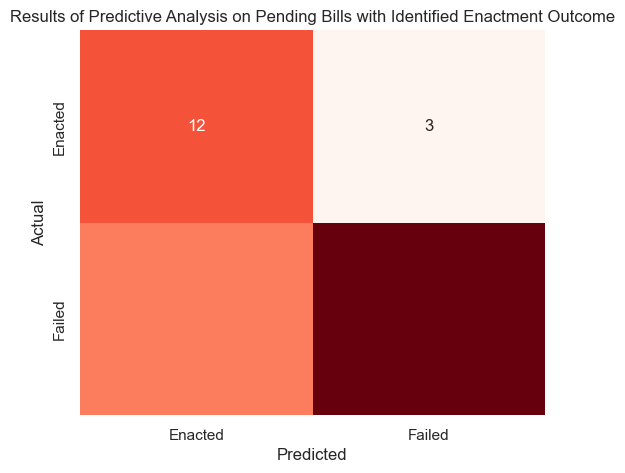

In [126]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Enacted", "Failed"], yticklabels=["Enacted", "Failed"], cbar=False)
plt.title("Results of Predictive Analysis on Pending Bills with Identified Enactment Outcome")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: 0.7045
Precision (Enacted): 0.5455
Recall (Enacted): 0.8000
Precision (Failed): 0.8636
Recall (Failed): 0.6552


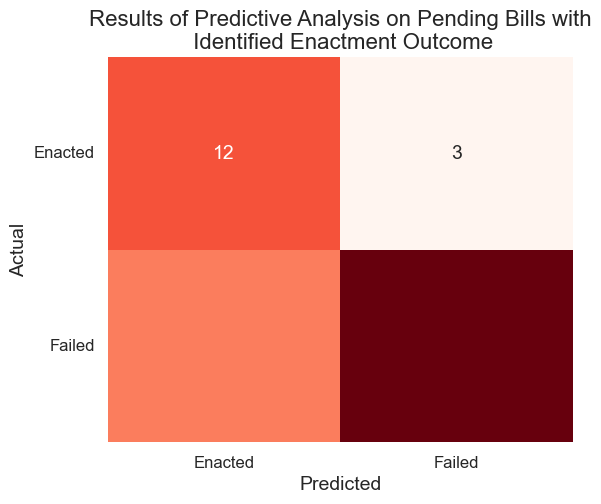

In [127]:
cm = confusion_matrix(validation["Actual Status"], validation["PredictedStatus"], labels=["Enacted", "Failed"])

# Compute accuracy
accuracy = accuracy_score(validation["Actual Status"], validation["PredictedStatus"])

# Compute precision and recall for both classes ("Enacted" and "Failed")
precision_enacted = precision_score(validation["Actual Status"], validation["PredictedStatus"], average="binary", pos_label="Enacted")
recall_enacted = recall_score(validation["Actual Status"], validation["PredictedStatus"], average="binary", pos_label="Enacted")

# Precision and Recall for "Failed"
precision_failed = precision_score(validation["Actual Status"], validation["PredictedStatus"], average="binary", pos_label="Failed")
recall_failed = recall_score(validation["Actual Status"], validation["PredictedStatus"], average="binary", pos_label="Failed")

# Output the results
print("Accuracy: {:.4f}".format(accuracy))
print(f"Precision (Enacted): {precision_enacted:.4f}")
print(f"Recall (Enacted): {recall_enacted:.4f}")
print(f"Precision (Failed): {precision_failed:.4f}")
print(f"Recall (Failed): {recall_failed:.4f}")

# Plot Confusion Matrix as a Heatmap with adjustments
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Enacted", "Failed"], yticklabels=["Enacted", "Failed"], cbar=False, annot_kws={"size": 14})
plt.title("Results of Predictive Analysis on Pending Bills with\n Identified Enactment Outcome", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.show()

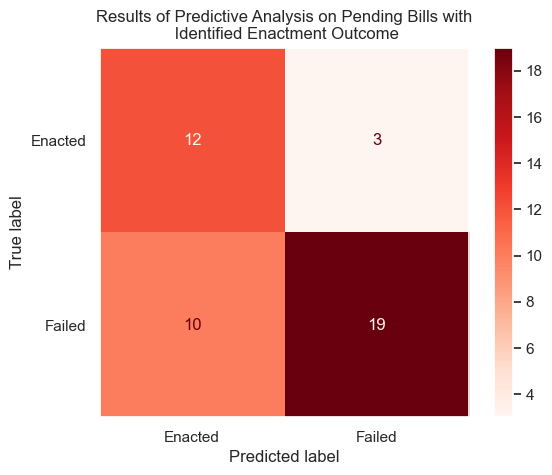

In [129]:
cm = confusion_matrix(validation["Actual Status"], validation["PredictedStatus"], labels=["Enacted", "Failed"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Enacted", "Failed"])
disp.plot(cmap='Reds')

plt.grid(False)
plt.title("Results of Predictive Analysis on Pending Bills with\n Identified Enactment Outcome") #\n(1 = Enacted, 0 = Failed)")
plt.show()